<a href="https://colab.research.google.com/github/mretana1999/Intro-to-AI/blob/main/assignment-3/AI_a3_mretanarodri2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
##Intro to Artificial Intelligence - COP 4630
---

###Assignment A3: Traveling Salesman Problem (TSP) using Ant Colony Optimization.

###**Developer and Reporter - Mauricio Retana**

###**Architect and Reporter - Juan Pablo Idrovo**

###**Architect - Reynaldo Williams**


###**Professor - Dr Marques**


### Due Date - July 25, 2021

### Code used as a reference and starting point: Code from the Grokking Artificial Intelligence Algorithms by Rishal Hurbans (chapter 6 ) URL: https://github.com/rishal-hurbans/Grokking-Artificial-Intelligence-Algorithms  
---

---
### Introduction
---

![picture](https://drive.google.com/uc?export=view&id=1nMeOXQM-7AA3b4OJS0N9aMBNdEWLTWhk)

The traveling salesman problem is about a salesman that travels trough cities that wants an efficient way to get to different cities by looking the shorter distance in between them. Similar to the Genetic Algorithms, Swarm intelligence optimization are a subset of the evolutionary algorithms. Furthermore, the ant colony optimization [ACO] algorithms are inspired by the behavior of ants moving efficiently between destinations, dropping pheromones, and acting on pheromones that they come across, states Hurbans in the book grokking Artificial Intelligence Algorithms.

While thinking about the solution to this problem, some questions arose. Questions like how are cities and distances represented? How do you create the initial population? How is the fitness score computed? And more. In the next paragraphs we are going to discuss the answers for such questions in detail.

---
## 1) Start by revising your understanding of ACO(in general) and planning how to attempt to solve the TSP using ACO. 
---

### For example: How will your knowledge of the TSP (from A2) might help you tackle some aspects of this assignment more quickly than you would otherwise (i.e., if you had to start from a different problem altogether)?

From our previous assignment, we learned about the Travelling Salesman Problem (TSP), and how to obtain optimal solutions through the use of Genetic Algorithms. Although this time we need a different approach to solve this problem, we already know to which constraints our solution is subject to and which is our ultimate goal. Having said this, our goal is to try find an optimal route in which the salesman will have visited every city once with the minimum distance travelled.

With this is mind, we notice that Ant Colony Optimization (ACO), which is a type of Swarm Intelligence algorithm, perfectly suits our requirements to solve the TSP problem. For instance, according to Hurbans, "swarm intelligence algorithms are useful for solving optimization problems when several constraints need to be met in a specific problem space and an absolute best solution is difficult to find" (Hurbans 155).

In order to solve TSP using ACO we first need  to represent the ants as a class in which each ant object has a memory of the cities visited, has the ability to decide which city to visit next, and also has the capability to retrieve its current fitness. These ant instances will make up a colony which can also be represented as a separate class. The colony class will control the actions of the swarm as a whole entity and at the same time it will keep in memory the pheromone trails as well as the best found route. Given this route, the colony class will have a method to find the distances for the entire colony. This ant colony class could also contain the graph that represents the grid of the cities, but that will depend on the design of our solution.


---
## 2) Break the problem down into parts and provide explicit answers to these questions:
---

### a) How were the cities and distances represented (as a data structure)?

In this assignment, each city is represented as a tuple of (x.y) coordinates which are chosen randomly in a grid of 200*200. For this assignment we decided not to make a city class, instead we followed the code sample from Hurban's code sample where a list of cities is created and each city is a tuple. Furthermore, as indicated in the instructions, for this problem, the size of the city list must be of 25.

The distances are represented in a 2D graph of size 25*25 (N * N cities) where the indexes of the graph elements match the indexes of the list of cities previously created. For example, if we want to know the distance between city 0 and city 9, we would look at the distances graph at the index [0][9] which is the same as the index [9][0]. Also, these distances are obtained by using the Euclidian distance formula.

![picture](https://drive.google.com/uc?export=view&id=1gaAzpEBC_agC3z8Ip2V8XfSczW3F9JXE)

It is important noting that this graph is 0 for indexes where i = j since the distance between a city and the same city is 0. We can also notice that the graph is symmetric accross this diagonal. Thus, the following code snippet (which was inspired by the user Rochakgupta on Github, listed on sources), will generate a graph of distances based on the list of cities created at the beginning of the code:


```
for i in range(CITY_COUNT):
    for j in range(i+1,CITY_COUNT):
        city_distances[i][j] = city_distances[j][i] = math.sqrt(pow(city_list[i][0] - city_list[j][0], 2) + pow(city_list[i][1] - city_list[j][1], 2))
```



In [ ]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

#Set seed for random library functions
random.seed(10)

# Create a list of cities in a grid of 200*200 by randomly choosing (x,y) coordinates
CITY_COUNT = 25
city_list = [(int(random.uniform(0,200)),int(random.uniform(0,200))) for i in range(CITY_COUNT)]
# Initialize the 2D matrix for storing distances between cities
city_distances = [[0]*CITY_COUNT for i in range(CITY_COUNT)]
# Fill 2D matrix with distances between each city
for i in range(CITY_COUNT):
    for j in range(i+1,CITY_COUNT):
        city_distances[i][j] = city_distances[j][i] = math.sqrt(pow(city_list[i][0] - city_list[j][0], 2) + pow(city_list[i][1] - city_list[j][1], 2))

---

### b) How did you encode the solution space?
---
The solution space is encoded in each ant object. As discussed earlier, each ant has the ability to "remember" which cities it has visited. This route of cities that the ant travels in each generation is stored as a list that contains the indexes of the visited cities in the original city list. We only store the indexes because the distances graphs works with the indexes as well and it has no knowledge of the (x,y) coordinates of each city. Therefore, the solution space is an ordered list that contains the indexes from 0 to 24, and the order in which these indexes appear is to be modified with each iteration of the program so that we find the shortest possible route. This shortest possible route will be found in the cities_visited attribute of the ant with the best fitness.


In [ ]:
class Ant:
    # The ant is initialized to a random city with no previously visited cities
    def __init__(self):
        self.visited_cities = []
        self.visited_cities.append(random.randint(0, CITY_COUNT - 1))

    # Select an city using a random chance or ACO function
    def visit_city(self, pheromone_trails):
        if random.random() < RANDOM_CITY_FACTOR:
            self.visited_cities.append(self.visit_random_city())
        else:
            if USER_SELECTED_OPTIONS_DICT['selection'] == '1':
                self.visited_cities.append(self.roulette_wheel_selection(self.visit_probabilistic_city(pheromone_trails)))
            elif USER_SELECTED_OPTIONS_DICT['selection'] == '2': 
                self.visited_cities.append(self.ranking_selection(self.visit_probabilistic_city(pheromone_trails)))

    # Select an city using a random chance
    def visit_random_city(self):
        all_cities = set(range(0, CITY_COUNT))
        possible_cities = all_cities - set(self.visited_cities)
        return random.randint(0, len(possible_cities) - 1)

    # Calculate probabilities of visiting adjacent unvisited cities
    def visit_probabilistic_city(self, pheromone_trails):
        current_city = self.visited_cities[-1]
        all_cities = set(range(0, CITY_COUNT))
        possible_cities = all_cities - set(self.visited_cities)
        possible_indexes = []
        possible_probabilities = []
        total_probabilities = 0
        for city in possible_cities:
            possible_indexes.append(city)
            pheromones_on_path = math.pow(pheromone_trails[current_city][city], ALPHA)
            heuristic_for_path = math.pow(1 / city_distances[current_city][city], BETA)
            probability = pheromones_on_path * heuristic_for_path
            possible_probabilities.append(probability)
            total_probabilities += probability
        possible_probabilities = [probability / total_probabilities for probability in possible_probabilities]
        return [possible_indexes, possible_probabilities, len(possible_cities)]

    def get_visited_cities(self):
        return self.visited_cities

    # Select an city using the probabilities of visiting adjacent unvisited cities
    @staticmethod
    def roulette_wheel_selection(probabilities):
        slices = []
        total = 0
        possible_indexes = probabilities[0]
        possible_probabilities = probabilities[1]
        possible_cities_count = probabilities[2]
        for i in range(0, possible_cities_count):
            slices.append([possible_indexes[i], total, total + possible_probabilities[i]])
            total += possible_probabilities[i]
        spin = random.random()
        result = [s[0] for s in slices if s[1] < spin <= s[2]]
        return result[0]
    
    @staticmethod
    def ranking_selection(probabilities):
        '''Apply linear ranking selection to select next city index'''
        slices = []
        total = 0
        possible_indexes = probabilities[0]
        fitness = probabilities[1]
        num_ranks = probabilities[2]
        ranked_possible_indexes = list(zip(possible_indexes,fitness))
        #Get indexes of sorted list of (index,fitness) tuples -sorted by fitness in ascending order-
        ranked_possible_indexes = [element[0] for element in sorted(ranked_possible_indexes,key = lambda element_:element_[1])]
        sum_all_ranks = sum(range(1,num_ranks + 1))
        possible_probabilities = [i/sum_all_ranks for i in range(1,num_ranks + 1)]
        #sum_possible_probabilities = sum(possible_probabilities)
        for i in range(0, num_ranks):
            slices.append([ranked_possible_indexes[i],total,total + possible_probabilities[i]])
            total += possible_probabilities[i]
        spin = random.random()
        result = [s[0] for s in slices if s[1] < spin <= s[2]]
        return result[0]

    # Get the total distance travelled by this ant
    def get_distance_travelled(self):
        total_distance = 0
        for a in range(1, len(self.visited_cities)):
            total_distance += city_distances[self.visited_cities[a]][self.visited_cities[a-1]]
        total_distance += city_distances[self.visited_cities[0]][self.visited_cities[len(self.visited_cities) - 1]]
        return total_distance

    def print_info(self):
        print('Ant ', self.__hash__())
        print('Total cities: ', len(self.visited_cities))
        print('Total distance: ', self.get_distance_travelled())

---

### c) How did you handle the creation of the initial ant population?
---
In this solution of ACO, the colony of ants is reset and re-created for each tour with the ACO class method setup_ants(). The number of ants to be created is decided by multiplying the number of cities times a constant factor value of 0.5. This means that the number of ants depends on the number of cities, more specifically, the number of ants is half the number of cities to be visited. Every time an ant object is created, a random city is appended to its list of visited cities, thus making every ant start at a different city which improves diversity.


In [ ]:
class ACO:

    def __init__(self, number_of_ants_factor):
        self.number_of_ants_factor = number_of_ants_factor
        # Initialize the array for storing ants
        self.ant_colony = []
        # Initialize the 2D matrix for pheromone trails
        self.pheromone_trails = []
        # Initialize the best distance in swarm
        self.best_distance = math.inf
        self.best_ant = None
        self.progress = [math.inf]
        self.best_route = []

    # Initialize ants at random starting locations
    def setup_ants(self, number_of_ants_factor):
        number_of_ants = round(CITY_COUNT * number_of_ants_factor)
        self.ant_colony.clear()
        for i in range(0, number_of_ants):
            self.ant_colony.append(Ant())

    # Initialize pheromone trails between cities
    def setup_pheromones(self):
        for r in range(0, len(city_distances)):
            pheromone_list = []
            for i in range(0, len(city_distances)):
                pheromone_list.append(1)
            self.pheromone_trails.append(pheromone_list)

    # Move all ants to a new city
    def move_ants(self, ant_population):
        for ant in ant_population:
            ant.visit_city(self.pheromone_trails)

    # Determine the best ant in the colony - after one tour of all cities
    def get_best(self, ant_population):
        for ant in ant_population:
            distance_travelled = ant.get_distance_travelled()
            if distance_travelled < self.best_distance:
                self.best_distance = distance_travelled
                self.best_ant = ant
        return self.best_ant
    
        # Update pheromone trails based ant movements - after one tour of all cities
    def update_pheromones(self, evaporation_rate):
        for x in range(0, CITY_COUNT):
            for y in range(0, CITY_COUNT):
                self.pheromone_trails[x][y] = self.pheromone_trails[x][y] * evaporation_rate
        for ant in self.ant_colony:
            visited_cities_pairs = []
            for i in range(len(ant.visited_cities)):
                visited_cities_pairs.append((ant.visited_cities[i] , ant.visited_cities[(i+1)%len(ant.visited_cities)]))
            for x in range(0, CITY_COUNT):
                for y in range(0, CITY_COUNT):
                    if (x,y) in visited_cities_pairs:
                        self.pheromone_trails[x][y] += 1 / ant.get_distance_travelled()
    
    def update_pheromones_elite(self):
        ''' Adds (1/distance) to the pheromone trails for the cities visited by the best ant '''
        visited_cities_pairs = []
        best_visited_cities = self.best_ant.visited_cities #indexes of cities visited by the best ant
        for i in range(len(best_visited_cities)):
            visited_cities_pairs.append((best_visited_cities[i] , best_visited_cities[(i+1)%len(best_visited_cities)]))
        for x in range(CITY_COUNT):
            for y in range(CITY_COUNT):
                if (x,y) in visited_cities_pairs:
                    self.pheromone_trails[x][y] += 1/self.best_ant.get_distance_travelled()


    # Tie everything together - this is the main loop
    def solve(self, total_iterations, evaporation_rate):
        self.setup_pheromones()
        stagnation_count = 0
        for i in range(0, TOTAL_ITERATIONS):
            self.setup_ants(NUMBER_OF_ANTS_FACTOR) 
            for r in range(0, CITY_COUNT - 1): #when colony is setup, ants have already visited 1 city
                self.move_ants(self.ant_colony)
            self.update_pheromones(evaporation_rate)
            self.best_ant = self.get_best(self.ant_colony)
            if USER_SELECTED_OPTIONS_DICT['pheromone update'] == '2':
                self.update_pheromones_elite()
            self.progress.append(self.best_ant.get_distance_travelled())
            print(i, ' Best distance: ', self.best_ant.get_distance_travelled())
            #Stagnation stop condition. Applied if user selected stagnation as condition.
            if USER_SELECTED_OPTIONS_DICT['stop condition'] == '2':
                if self.progress[i+1] <= self.progress[i] * 1.01:
                    stagnation_count += 1
                    if stagnation_count > 30:
                        print('Optimal solution has stagnated, stopping program!')
                        break
                else:
                    stagnation_count = 0

---

### d) How did you handle the updating of the pheromone trails?
---
Updating the pheromone trails is perhaps one of the most important steps towards finding a solution that converges to a minimum distance. These pheromone trails are updated based on two factors, the evaporation rate and the distance travelled by each ant.

The update of the pheromone trails happens after the colony of ants have completed a tour. All the pheromones are then divided by an arbitrary evaporation rate which helps to weaken the amount of pheromones on those paths that were not visited by the colony of ants. On the other hand, those frequently visited paths see an increase on their pheromone intensity since we add (1/distance travelled by each ant) to the existing amount of pheromones for the visited path. This also means that those ants that found shorter paths provide a greater amount of pheromones to the paths that lead to shorter routes. The following diagram by Hurbans clearly depicts the process of updating the pheromone trails:

![picture](https://drive.google.com/uc?export=view&id=1ezh3MM7zRL1wLWH9fxR54HcbHJZIdRm1)

It is important to note that our starter code did not implement this process correctly. This is because every path in the pheromone trails gets updated by the same value every time. This results with a pheromone trails graph with the same weight for every pair of nodes. The following code snippet shows the erroneous implementation of this step:



```
def update_pheromones(self, evaporation_rate):
        for x in range(0, CITY_COUNT):
            for y in range(0, CITY_COUNT):
                self.pheromone_trails[x][y] = self.pheromone_trails[x][y] * evaporation_rate
                for ant in self.ant_colony:
                    self.pheromone_trails[x][y] += 1 / ant.get_distance_travelled() #adds the same value to all cities DOES NOT WORK AS INTENDED
```

Our team decided to try and implement a new function that provides the correct behaviour as explained by Hurbans in the GAIA textbook. The following is our own implementation for this step:

```
    def update_pheromones(self, evaporation_rate):
        for x in range(0, CITY_COUNT):
            for y in range(0, CITY_COUNT):
                self.pheromone_trails[x][y] = self.pheromone_trails[x][y] * evaporation_rate
                for ant in self.ant_colony:
                    visited_cities_pairs = []
                    for i in range(len(ant.visited_cities)):
                        visited_cities_pairs.append((ant.visited_cities[i],ant.visited_cities[(i+1)%len(ant.visited_cities)]))
                    if (x,y) in visited_cities_pairs:
                        self.pheromone_trails[x][y] += 1 / ant.get_distance_travelled()
```

UPDATE: The implementation shown above however, is computationally expensive due to the excessive amount of nested loops. So, we decided to refine the update pheromones function and this is the final and more optimized result:

```
    def update_pheromones(self, evaporation_rate):
        for x in range(0, CITY_COUNT):
            for y in range(0, CITY_COUNT):
                self.pheromone_trails[x][y] = self.pheromone_trails[x][y] * evaporation_rate
        for ant in self.ant_colony:
            visited_cities_pairs = []
            for i in range(len(ant.visited_cities)):
                visited_cities_pairs.append((ant.visited_cities[i],ant.visited_cities[(i+1)%len(ant.visited_cities)]))
            for x in range(0, CITY_COUNT):
                for y in range(0, CITY_COUNT):
                    if (x,y) in visited_cities_pairs:
                        self.pheromone_trails[x][y] += 1 / ant.get_distance_travelled()
```

These modifications to the implementation of the update of pheromone trails had a positive impact on both the final solution and the computational performance of our algorithm. These results will be discussed later in the final question.

---

### e) Which strategy(ies) did you use to compute the best solution?
---
Each ant has a method that allows it to calculate the total distance from its list of visited cities. Once the ant has completed a tour it can calculate the distance it has travelled with this method.

```
    def get_distance_travelled(self):
        total_distance = 0
        for a in range(1, len(self.visited_cities)):
            total_distance += city_distances[self.visited_cities[a]][self.visited_cities[a-1]]
        total_distance += city_distances[self.visited_cities[0]][self.visited_cities[len(self.visited_cities) - 1]]
        return total_distance
```

As we can see, this method uses the indexes of the cities visited by an ant, and those indexes are then mapped to the distances graph that was defined globally. 

This method is then called iteratively by the ACO class instance for all the ants in the colony and the shortest distance is used to determine the ant with the best solution:

```
    def get_best(self, ant_population):
        for ant in ant_population:
            distance_travelled = ant.get_distance_travelled()
            if distance_travelled < self.best_distance:
                self.best_distance = distance_travelled
                self.best_ant = ant
        return self.best_ant
```
With this, the best ant and the best distance is stored as an attribute of the ACO object. This is useful to update the pheromone trails as well as to graph the best found solution to the TSP problem.



---

### f) Which stopping condition did you use? Why?

---
The starter code uses a specific number of iterations or tours in which each ant from the colony visits all the cities once. This number of iterations is specified by the variable TOTAL_ITERATIONS which is set to 100, which can be changed to any other positive integer value. This is certainly not the most effective stopping condition, for instance, when running the program for a list of cities of size 25, the program usually converges at around 30 iterations:

![picture](https://drive.google.com/uc?export=view&id=1txLu1Ui_eht5TZPy3ftFOtmq3sWMctJ6)

In order to solve this we will also add an option that stops the program when the optimal found solution stagnates.

In [ ]:
def parse_visited_cities_indexes(visited_cities_indexes):
    """Returns a route list which is a list with the (x,y) coordinate tuples, given the indexes of the original city_list."""
    # Visited cities' coordinates + initial city coordinates
    return [city_list[index] for index in visited_cities_indexes] + [city_list[visited_cities_indexes[0]]]

def plot_progress(progress):
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.title('Best route across generations')
    plt.show()

def plot_route(route, subplot_title = ""):
    #create and show cities' positions subplots
    x = [coordinate[0] for coordinate in route]
    y = [coordinate[1] for coordinate in route]
    plt.subplot(1,2,1)
    plt.scatter(x,y, color = 'b')
    plt.ylabel('y-coordinates')
    plt.xlabel('x-coordinates')
    plt.title('Position of cities to be visited')
    #create and show current optimal route
    plt.subplot(1,2,2)
    plt.plot(x,y, color = 'r', zorder = 2) #draw connecting lines
    plt.scatter(x,y, color = 'b', zorder = 1) #draw dots
    plt.ylabel('y-coordinates')
    plt.xlabel('x-coordinates')
    plt.title('Best current solution')
    plt.suptitle(subplot_title)
    plt.show()

def pretty_print_route(route):
    ''' Pretty prints route list of tuples'''
    print('The optimal route found is: ', end='')
    for i in range(len(route) - 1):
        if i % 10 == 0 : print()
        print(f"{route[i]} -> ", end='')
    print(route[0])

def get_user_selection():
    ''' Gets user choice for selection, pheromone update, and stop condition strategies '''
    for step in OPTIONS_AVAILABLE_DICT:
        print(f"Which option would you like for **{step}** ")
        for option, description in OPTIONS_AVAILABLE_DICT[step].items():
            print(f"Option {option} : {description}")
        while True:
            decision = input(f" Enter your selection for **{step}**: ")
            if decision in OPTIONS_AVAILABLE_DICT[step]:
                USER_SELECTED_OPTIONS_DICT[step] = decision
                break
            else:
                print('Invalid input, try again: ')
                continue
    print('\nYour final selection is: ')
    for step, decision_num in USER_SELECTED_OPTIONS_DICT.items():
        print(f"{step}: {decision_num} {OPTIONS_AVAILABLE_DICT[step][decision_num]}")
    print('Please wait for the program to finish running.')

#Dictionary used to print the available options to the user
OPTIONS_AVAILABLE_DICT = {
                            'selection':{'1':'Roulette Wheel Selection','2':'Ranking Selection'},
                            'pheromone update':{'1':'Normal update', '2':'Favor elite ant trails'},
                            'stop condition':{'1':'Specified number of Generations', '2':'Stop if no improvement (Stagnation)'}
                        }

#Dictionary that is used to map user input to available options
USER_SELECTED_OPTIONS_DICT = {'selection':'1', 'pheromone update':'1', 'stop condition':'1'}

---

### g) What other parameters, design choices, initialization and configuration steps are relevant to your design and implementation?

---

Another relevant design choice is the **selection strategy** that our program implements. The starter code uses Roulette Wheel Selection to choose which city each ants visits next. The roulette wheel consists of generating a list of slices where each slice represents one possible city to visit. The area of this slice is given based on the fitness of the given city, and this fitness is calculated using the distance heuristics and the pheromone intensities of the cities. Therefore, those cities with shorter distance from the current city and with more pheromones have greater chances of being selected. Our team decided to implement ranking selection which is a variant of roulette wheel selection which divides the slices of the wheel based on a ranking system. We will further discuss the results of using this selection method in the next question.

Other relevant parameters include the value of **Alpha and Beta**. These two values are important when selecting the next city that the ants visit next. As mentioned above, roulette wheel selection depends on the value of the pheromone trails and the distance heuristics. The probability of choosing a certain city is determined by using the following formula:

![picture](https://drive.google.com/uc?export=view&id=1CDQ5UJGxWOe0TwVaJvL3h6ORSMgmcilP)

From this formula, we can see that alpha and beta are used to decide wheter the pheromones or the heuristics will have more influence on the selection of the next city. If a > b then the pheromones have greater influence and vice versa.

Other important parameter that impacts our final solution is the **Random City Factor**. This parameter improves the diversity of our solutions by adding a random selection of the next city to be visited by the ant. This random selection occurs only if a randomly chosen number is less than the value of the random factor.


Which option would you like for **selection** 
Option 1 : Roulette Wheel Selection
Option 2 : Ranking Selection
 Enter your selection for **selection**: 1
Which option would you like for **pheromone update** 
Option 1 : Normal update
Option 2 : Favor elite ant trails
 Enter your selection for **pheromone update**: 1
Which option would you like for **stop condition** 
Option 1 : Specified number of Generations
Option 2 : Stop if no improvement (Stagnation)
 Enter your selection for **stop condition**: 2

Your final selection is: 
selection: 1 Roulette Wheel Selection
pheromone update: 1 Normal update
stop condition: 2 Stop if no improvement (Stagnation)
Please wait for the program to finish running.


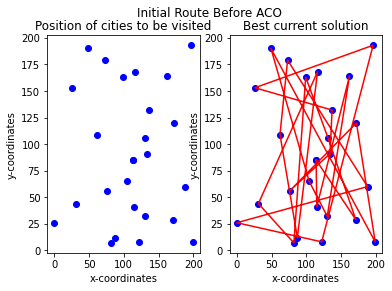

0  Best distance:  1071.995059085015
1  Best distance:  1071.995059085015
2  Best distance:  1071.995059085015
3  Best distance:  1071.995059085015
4  Best distance:  1071.995059085015
5  Best distance:  1071.995059085015
6  Best distance:  1071.995059085015
7  Best distance:  1071.995059085015
8  Best distance:  1056.5060835720672
9  Best distance:  1006.6464232007725
10  Best distance:  1006.6464232007725
11  Best distance:  1006.6464232007725
12  Best distance:  1006.6464232007725
13  Best distance:  1006.6464232007725
14  Best distance:  1006.6464232007725
15  Best distance:  1006.6464232007725
16  Best distance:  1006.6464232007725
17  Best distance:  1006.6464232007725
18  Best distance:  1006.6464232007725
19  Best distance:  1006.6464232007725
20  Best distance:  1006.6464232007725
21  Best distance:  1006.6464232007725
22  Best distance:  1006.6464232007725
23  Best distance:  1006.6464232007725
24  Best distance:  1006.6464232007725
25  Best distance:  1006.6464232007725
26  

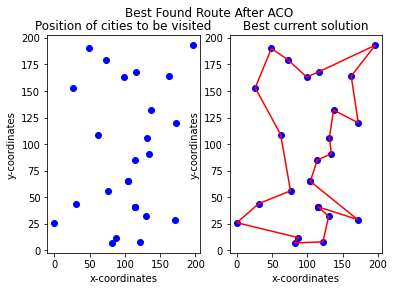

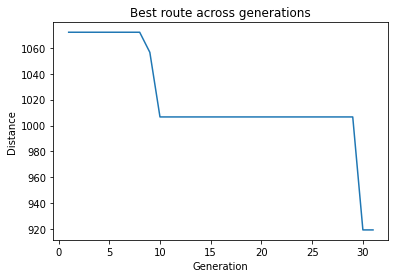

In [ ]:
# Set the percentage of ants based on the total number of cities
NUMBER_OF_ANTS_FACTOR = 0.5
# Set the number of tours ants must complete
TOTAL_ITERATIONS = 100
# Set the rate of pheromone evaporation (0.0 - 1.0)
EVAPORATION_RATE = 0.4
# Set the probability of ants choosing a random city to visit (0.0 - 1.0)
RANDOM_CITY_FACTOR = 0.15
# Set the weight for pheromones on path for selection
ALPHA = 4
# Set the weight for heuristic of path for selection
BETA = 7

get_user_selection()
initial_route = city_list + [city_list[0]]
plot_route(initial_route,'Initial Route Before ACO')
aco = ACO(NUMBER_OF_ANTS_FACTOR)
aco.solve(TOTAL_ITERATIONS, EVAPORATION_RATE)
route = parse_visited_cities_indexes(aco.best_ant.get_visited_cities())
pretty_print_route(route)
plot_route(route, 'Best Found Route After ACO')
plot_progress(aco.progress)

---

### h) Which (simple) experiments have you run to observe the impact of different design decisions and parameter values? Post their results and your comments

---

***Ranking Selection:***

The experiment that we decided to implement is in the selection strategy. Instead of using roulette wheel selection, which was in the starter code, we used ranking selection. As mentioned before, the ranking selection divides the slices of the wheel based on a ranking system. Ranking Selection is recognized by the weight that each candidate has. This weight that is given by taking in consideration the fitness, is the one that makes the canditate more likely to be chosen. The higher the rank, the higher the probability.

After implementing both, roulette selection and ranking selection, we realized that in this specific example the results weren't what we espected. Below I attached the results for Ranking Selection.

``` 
Results for ranking selection:

0  Best distance:  2055.6821593870263
1  Best distance:  2055.6821593870263
2  Best distance:  1933.0521644750315
3  Best distance:  1933.0521644750315
4  Best distance:  1933.0521644750315
5  Best distance:  1807.007410277019
6  Best distance:  1807.007410277019
7  Best distance:  1807.007410277019
8  Best distance:  1807.007410277019
9  Best distance:  1807.007410277019
10  Best distance:  1807.007410277019
11  Best distance:  1807.007410277019
12  Best distance:  1807.007410277019
13  Best distance:  1807.007410277019
14  Best distance:  1807.007410277019
15  Best distance:  1807.007410277019
16  Best distance:  1807.007410277019
17  Best distance:  1807.007410277019
18  Best distance:  1807.007410277019
19  Best distance:  1807.007410277019
20  Best distance:  1807.007410277019
21  Best distance:  1807.007410277019
22  Best distance:  1807.007410277019
23  Best distance:  1807.007410277019
24  Best distance:  1807.007410277019
25  Best distance:  1807.007410277019
26  Best distance:  1807.007410277019
27  Best distance:  1807.007410277019
28  Best distance:  1807.007410277019
29  Best distance:  1807.007410277019
30  Best distance:  1807.007410277019
Optimal solution has stagnated, stopping program!
 ```

We were impressed after looking the results of the Ranking Selection and the results for the Roulette Selection. Below we have the results for the Roulette Selections, which in this case are more efficient and faster. We see that in the same amount of iterations, the distance improves significantly.

```
Results for roulette selection:

0  Best distance:  1203.3691922590608
1  Best distance:  1112.4582449854381
2  Best distance:  1112.4582449854381
3  Best distance:  1112.4582449854381
4  Best distance:  1071.7594404226068
5  Best distance:  1019.5033932227735
6  Best distance:  980.5455359051272
7  Best distance:  980.5455359051272
8  Best distance:  980.5455359051272
9  Best distance:  980.5455359051272
10  Best distance:  980.5455359051272
11  Best distance:  980.5455359051272
12  Best distance:  980.5455359051272
13  Best distance:  980.5455359051272
14  Best distance:  980.5455359051272
15  Best distance:  980.5455359051272
16  Best distance:  980.5455359051272
17  Best distance:  980.5455359051272
18  Best distance:  980.5455359051272
19  Best distance:  980.5455359051272
20  Best distance:  980.5455359051272
21  Best distance:  980.5455359051272
22  Best distance:  980.5455359051272
23  Best distance:  980.5455359051272
24  Best distance:  980.5455359051272
25  Best distance:  980.5455359051272
26  Best distance:  980.5455359051272
27  Best distance:  980.5455359051272
28  Best distance:  980.5455359051272
29  Best distance:  980.5455359051272
30  Best distance:  980.5455359051272
Optimal solution has stagnated, stopping program!
```

***Random City Factor:***

Other important experiment is the rendom city factor, this impacts our final solution as well. By adding a random selection of the next city, it improves the diversity of the solution. The RCF [Random City Factor] was 0.0 [0.0 - 1.0] and then we decided to implement it in the last block of code. We increased the RCF by 0.15. As a result, we increased the probability of ants choosing a random city to visit. Below we have the results* while the RCF is equal to 0.0 and a total of iterations equal to 100.

``` 
RANDOM_CITY_FACTOR = 0.0

0  Best distance:  1138.5051326530283
1  Best distance:  1053.8298283134543
2  Best distance:  1053.8298283134543
3  Best distance:  1053.8298283134543
4  Best distance:  1053.8298283134543
5  Best distance:  1053.8298283134543
6  Best distance:  990.2755782271112
7  Best distance:  984.3813799725045
8  Best distance:  984.3813799725045
9  Best distance:  984.3813799725045
10  Best distance:  984.3813799725045
21  Best distance:  984.3813799725045
22  Best distance:  984.3813799725045
23  Best distance:  984.3813799725045
24  Best distance:  984.3813799725045
25  Best distance:  984.3813799725045
26  Best distance:  984.3813799725045
27  Best distance:  984.3813799725045
28  Best distance:  984.3813799725045
29  Best distance:  984.3813799725045
30  Best distance:  984.3813799725045
41  Best distance:  984.3813799725045
42  Best distance:  984.3813799725045
43  Best distance:  984.3813799725045
44  Best distance:  984.3813799725045
45  Best distance:  984.3813799725045
46  Best distance:  984.3813799725045
47  Best distance:  984.3813799725045
48  Best distance:  984.3813799725045
49  Best distance:  984.3813799725045
60  Best distance:  984.3813799725045
61  Best distance:  984.3813799725045
62  Best distance:  984.3813799725045
63  Best distance:  984.3813799725045
64  Best distance:  984.3813799725045
65  Best distance:  984.3813799725045
66  Best distance:  984.3813799725045
67  Best distance:  984.3813799725045
68  Best distance:  984.3813799725045
69  Best distance:  984.3813799725045
80  Best distance:  984.3813799725045
81  Best distance:  984.3813799725045
82  Best distance:  984.3813799725045
83  Best distance:  984.3813799725045
84  Best distance:  984.3813799725045
85  Best distance:  984.3813799725045
86  Best distance:  984.3813799725045
87  Best distance:  984.3813799725045
88  Best distance:  984.3813799725045
89  Best distance:  984.3813799725045
90  Best distance:  984.3813799725045
91  Best distance:  984.3813799725045
92  Best distance:  984.3813799725045
93  Best distance:  984.3813799725045
94  Best distance:  984.3813799725045
95  Best distance:  984.3813799725045
96  Best distance:  984.3813799725045
97  Best distance:  984.3813799725045
98  Best distance:  984.3813799725045
99  Best distance:  984.3813799725045

*For space purposes, we deleted some best distances results

```

After aplying the RCF, we can clearly realize that the results are much better now. We have a shorter distance thanks to the RCF, since the program was given a chance of divercify the visits of other cities by a small probability. Below we have the results* while the RCF is equal to 0.15 and a total of iterations equal to 100.

```
RANDOM_CITY_FACTOR = 0.15

0  Best distance:  1071.995059085015
1  Best distance:  1071.995059085015
2  Best distance:  1071.995059085015
3  Best distance:  1071.995059085015
4  Best distance:  1071.995059085015
5  Best distance:  1071.995059085015
6  Best distance:  1071.995059085015
7  Best distance:  1071.995059085015
8  Best distance:  1056.5060835720672
9  Best distance:  1006.6464232007725
10  Best distance:  1006.6464232007725
11  Best distance:  1006.6464232007725
12  Best distance:  1006.6464232007725
13  Best distance:  1006.6464232007725
14  Best distance:  1006.6464232007725
15  Best distance:  1006.6464232007725
16  Best distance:  1006.6464232007725
17  Best distance:  1006.6464232007725
18  Best distance:  1006.6464232007725
19  Best distance:  1006.6464232007725
20  Best distance:  1006.6464232007725
21  Best distance:  1006.6464232007725
40  Best distance:  919.4746693581885
41  Best distance:  919.4746693581885
42  Best distance:  919.4746693581885
43  Best distance:  919.4746693581885
44  Best distance:  919.4746693581885
45  Best distance:  919.4746693581885
46  Best distance:  919.4746693581885
47  Best distance:  919.4746693581885
48  Best distance:  919.4746693581885
49  Best distance:  919.4746693581885
50  Best distance:  919.4746693581885
51  Best distance:  919.4746693581885
52  Best distance:  919.4746693581885
53  Best distance:  919.4746693581885
54  Best distance:  919.4746693581885
55  Best distance:  919.4746693581885
56  Best distance:  919.4746693581885
57  Best distance:  919.4746693581885
58  Best distance:  919.4746693581885
59  Best distance:  919.4746693581885
60  Best distance:  919.4746693581885
61  Best distance:  919.4746693581885
80  Best distance:  919.4746693581885
81  Best distance:  919.4746693581885
82  Best distance:  919.4746693581885
83  Best distance:  919.4746693581885
84  Best distance:  919.4746693581885
85  Best distance:  919.4746693581885
86  Best distance:  919.4746693581885
87  Best distance:  919.4746693581885
88  Best distance:  919.4746693581885
89  Best distance:  919.4746693581885
90  Best distance:  919.4746693581885
91  Best distance:  919.4746693581885
92  Best distance:  919.4746693581885
93  Best distance:  919.4746693581885
94  Best distance:  919.4746693581885
95  Best distance:  919.4746693581885
96  Best distance:  919.4746693581885
97  Best distance:  919.4746693581885
98  Best distance:  919.4746693581885
99  Best distance:  919.4746693581885

*For space purposes, we deleted some best distances results
```


**Alpha and Beta:**

We saw that changing the values of alpha and beta had significant changes in the results since the "variables can be adjusted to balance the ant's judgment between making a move based on what it knows versus pheromone trails...", the author mentions. First, we had alpha equal to 4 and beta to 7. In addition, we had 100 iterations, and the random factor of 0.15. Below we have the results*.


```
Results for alpha = 4 and beta = 7


0  Best distance:  1071.995059085015
1  Best distance:  1071.995059085015
2  Best distance:  1071.995059085015
3  Best distance:  1071.995059085015
4  Best distance:  1071.995059085015
5  Best distance:  1071.995059085015
6  Best distance:  1071.995059085015
7  Best distance:  1071.995059085015
8  Best distance:  1056.5060835720672
9  Best distance:  1006.6464232007725
10  Best distance:  1006.6464232007725
11  Best distance:  1006.6464232007725
12  Best distance:  1006.6464232007725
13  Best distance:  1006.6464232007725
14  Best distance:  1006.6464232007725
15  Best distance:  1006.6464232007725
16  Best distance:  1006.6464232007725
17  Best distance:  1006.6464232007725
18  Best distance:  1006.6464232007725
19  Best distance:  1006.6464232007725
26  Best distance:  1006.6464232007725
27  Best distance:  1006.6464232007725
28  Best distance:  1006.6464232007725
29  Best distance:  919.4746693581885
30  Best distance:  919.4746693581885
31  Best distance:  919.4746693581885
91  Best distance:  919.4746693581885
92  Best distance:  919.4746693581885
93  Best distance:  919.4746693581885
94  Best distance:  919.4746693581885
95  Best distance:  919.4746693581885
96  Best distance:  919.4746693581885
97  Best distance:  919.4746693581885
98  Best distance:  919.4746693581885
99  Best distance:  919.4746693581885


*For space purposes, we deleted some best distances results
```


After changing the variables by inverting the values [alpha = 7 and beta = 4], but without changing the 100 iterations nor, the random factor of 0.15. We had a better result, a shorter distance. Below we have the results* of the iterations.

```
Results for alpha = 7 and beta = 4

0  Best distance:  1177.1418194596497
1  Best distance:  1177.1418194596497
2  Best distance:  1177.1418194596497
3  Best distance:  1177.1418194596497
4  Best distance:  1177.1418194596497
5  Best distance:  1177.1418194596497
6  Best distance:  976.573818281379
7  Best distance:  976.573818281379
8  Best distance:  976.573818281379
9  Best distance:  976.573818281379
10  Best distance:  976.573818281379
11  Best distance:  976.573818281379
12  Best distance:  976.573818281379
13  Best distance:  976.573818281379
14  Best distance:  888.0485572614596
30  Best distance:  888.0485572614596
31  Best distance:  888.0485572614596
32  Best distance:  888.0485572614596
33  Best distance:  888.0485572614596
54  Best distance:  888.0485572614596
55  Best distance:  888.0485572614596
56  Best distance:  888.0485572614596
57  Best distance:  888.0485572614596
58  Best distance:  888.0485572614596
59  Best distance:  888.0485572614596
60  Best distance:  888.0485572614596
61  Best distance:  888.0485572614596
62  Best distance:  888.0485572614596
63  Best distance:  888.0485572614596
64  Best distance:  888.0485572614596
65  Best distance:  888.0485572614596
66  Best distance:  888.0485572614596
95  Best distance:  888.0485572614596
96  Best distance:  888.0485572614596
97  Best distance:  888.0485572614596
98  Best distance:  888.0485572614596
99  Best distance:  888.0485572614596


*For space purposes, we deleted some best distances result
```



**Evaporation Rate:**


As the author states, the evaporation factor is the one that multiplies itself by the value of the pheromones in order to create a paramenter than can be used for the algorithm in terms of exploration and exploitation. If we set the evaporation rate equal at 0.4, we will get the results* below.

```
EVAPORATION_RATE = 0.4

0  Best distance:  1172.2275157288561
1  Best distance:  1172.2275157288561
2  Best distance:  1172.2275157288561
3  Best distance:  1172.2275157288561
4  Best distance:  1172.2275157288561
5  Best distance:  1162.956105792151
6  Best distance:  1152.9310283731163
7  Best distance:  1138.007542841385
8  Best distance:  1124.5493950819514
9  Best distance:  1102.638901358402
10  Best distance:  874.2051858304363
90  Best distance:  874.2051858304363
91  Best distance:  874.2051858304363
92  Best distance:  874.2051858304363
93  Best distance:  874.2051858304363
94  Best distance:  874.2051858304363
95  Best distance:  874.2051858304363
96  Best distance:  874.2051858304363
97  Best distance:  874.2051858304363
98  Best distance:  874.2051858304363
99  Best distance:  874.2051858304363

*For space purposes, we deleted some best distances result


```

Lets say we change the evaporation rate equal to 0.8, we will have different results. Below we have the results.

```
EVAPORATION_RATE = 0.8

0  Best distance:  1258.0590173766223
1  Best distance:  1258.0590173766223
2  Best distance:  1079.3263984223631
14  Best distance:  1079.3263984223631
15  Best distance:  1079.3263984223631
16  Best distance:  1028.6107126642155
17  Best distance:  1028.6107126642155
18  Best distance:  1028.6107126642155
19  Best distance:  1028.6107126642155
20  Best distance:  1028.6107126642155
21  Best distance:  1028.6107126642155
22  Best distance:  1028.6107126642155
23  Best distance:  1028.6107126642155
24  Best distance:  1006.3886850246764
25  Best distance:  1006.3886850246764
35  Best distance:  1006.3886850246764
36  Best distance:  1006.3886850246764
37  Best distance:  1006.3886850246764
38  Best distance:  991.4431402557225
39  Best distance:  991.4431402557225
45  Best distance:  991.4431402557225
46  Best distance:  991.4431402557225
47  Best distance:  975.8673408981081
90  Best distance:  975.8673408981081
91  Best distance:  975.8673408981081
92  Best distance:  975.8673408981081
93  Best distance:  975.8673408981081
94  Best distance:  975.8673408981081
95  Best distance:  975.8673408981081
96  Best distance:  975.8673408981081
97  Best distance:  975.8673408981081
98  Best distance:  975.8673408981081
99  Best distance:  975.8673408981081


*For space purposes, we deleted some best distances result


```


**Ants Factor:**


The ant factor is a percentage of the total number of attractions. The percentage of ants is based on the total number of cities, in this case the ant factor is 50% of the attractions. As a result, we have the data* below.

```
NUMBER_OF_ANTS_FACTOR = 0.5

0  Best distance:  1221.0103768246963
1  Best distance:  1084.2264617481283
2  Best distance:  1082.046260371449
3  Best distance:  1082.046260371449
4  Best distance:  1082.046260371449
5  Best distance:  1030.741437548821
6  Best distance:  1030.741437548821
7  Best distance:  1020.8243900835961
8  Best distance:  1020.8243900835961
9  Best distance:  1020.8243900835961
10  Best distance:  1020.8243900835961
11  Best distance:  1015.7148888882817
12  Best distance:  967.5052969114129
13  Best distance:  967.5052969114129
90  Best distance:  960.3405681499981
92  Best distance:  960.3405681499981
93  Best distance:  960.3405681499981
94  Best distance:  960.3405681499981
95  Best distance:  960.3405681499981
96  Best distance:  935.3610327837375
97  Best distance:  935.3610327837375
98  Best distance:  935.3610327837375
99  Best distance:  935.3610327837375


*For space purposes, we deleted some best distances result


```
If we change the value of the ant factor to 0.1 instead of 0.5 we do have a drastic change. The result is less efficient since the distances are higher than the past result. Below we have the results* for the ant factor being 0.1.

```
NUMBER_OF_ANTS_FACTOR = 0.1

0  Best distance:  1535.5391938600037
1  Best distance:  1525.7168861523505
2  Best distance:  1204.9668548552354
3  Best distance:  1204.9668548552354
4  Best distance:  1204.9668548552354
5  Best distance:  1183.9596821104856
6  Best distance:  1183.9596821104856
9  Best distance:  1183.9596821104856
10  Best distance:  1183.9596821104856
11  Best distance:  1158.1231235316282
12  Best distance:  1158.1231235316282
17  Best distance:  1158.1231235316282
18  Best distance:  1093.7444727399684
19  Best distance:  1093.7444727399684
20  Best distance:  1093.7444727399684
90  Best distance:  1093.7444727399684
91  Best distance:  1093.7444727399684
92  Best distance:  1093.7444727399684
93  Best distance:  1093.7444727399684
94  Best distance:  1093.7444727399684
95  Best distance:  1093.7444727399684
96  Best distance:  1093.7444727399684
97  Best distance:  1093.7444727399684
98  Best distance:  1093.7444727399684
99  Best distance:  1093.7444727399684


*For space purposes, we deleted some best distances result

```

# Placing all the pieces of code together:

In [ ]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

#Set seed for random library functions
random.seed(10)

# Create a list of cities in a grid of 200*200 by randomly choosing (x,y) coordinates
CITY_COUNT = 25
city_list = [(int(random.uniform(0,200)),int(random.uniform(0,200))) for i in range(CITY_COUNT)]
# Initialize the 2D matrix for storing distances between cities
city_distances = [[0]*CITY_COUNT for i in range(CITY_COUNT)]
# Fill 2D matrix with distances between each city
for i in range(CITY_COUNT):
    for j in range(i+1,CITY_COUNT):
        city_distances[i][j] = city_distances[j][i] = math.sqrt(pow(city_list[i][0] - city_list[j][0], 2) + pow(city_list[i][1] - city_list[j][1], 2))

class Ant:
    # The ant is initialized to a random city with no previously visited cities
    def __init__(self):
        self.visited_cities = []
        self.visited_cities.append(random.randint(0, CITY_COUNT - 1))

    # Select an city using a random chance or ACO function
    def visit_city(self, pheromone_trails):
        if random.random() < RANDOM_CITY_FACTOR:
            self.visited_cities.append(self.visit_random_city())
        else:
            if USER_SELECTED_OPTIONS_DICT['selection'] == '1':
                self.visited_cities.append(self.roulette_wheel_selection(self.visit_probabilistic_city(pheromone_trails)))
            elif USER_SELECTED_OPTIONS_DICT['selection'] == '2': 
                self.visited_cities.append(self.ranking_selection(self.visit_probabilistic_city(pheromone_trails)))

    # Select an city using a random chance
    def visit_random_city(self):
        all_cities = set(range(0, CITY_COUNT))
        possible_cities = all_cities - set(self.visited_cities)
        return random.randint(0, len(possible_cities) - 1)

    # Calculate probabilities of visiting adjacent unvisited cities
    def visit_probabilistic_city(self, pheromone_trails):
        current_city = self.visited_cities[-1]
        all_cities = set(range(0, CITY_COUNT))
        possible_cities = all_cities - set(self.visited_cities)
        possible_indexes = []
        possible_probabilities = []
        total_probabilities = 0
        for city in possible_cities:
            possible_indexes.append(city)
            pheromones_on_path = math.pow(pheromone_trails[current_city][city], ALPHA)
            heuristic_for_path = math.pow(1 / city_distances[current_city][city], BETA)
            probability = pheromones_on_path * heuristic_for_path
            possible_probabilities.append(probability)
            total_probabilities += probability
        possible_probabilities = [probability / total_probabilities for probability in possible_probabilities]
        return [possible_indexes, possible_probabilities, len(possible_cities)]

    def get_visited_cities(self):
        return self.visited_cities

    # Select an city using the probabilities of visiting adjacent unvisited cities
    @staticmethod
    def roulette_wheel_selection(probabilities):
        slices = []
        total = 0
        possible_indexes = probabilities[0]
        possible_probabilities = probabilities[1]
        possible_cities_count = probabilities[2]
        for i in range(0, possible_cities_count):
            slices.append([possible_indexes[i], total, total + possible_probabilities[i]])
            total += possible_probabilities[i]
        spin = random.random()
        result = [s[0] for s in slices if s[1] < spin <= s[2]]
        return result[0]
    
    @staticmethod
    def ranking_selection(probabilities):
        '''Apply linear ranking selection to select next city index'''
        slices = []
        total = 0
        possible_indexes = probabilities[0]
        fitness = probabilities[1]
        num_ranks = probabilities[2]
        ranked_possible_indexes = list(zip(possible_indexes,fitness))
        #Get indexes of sorted list of (index,fitness) tuples -sorted by fitness in ascending order-
        ranked_possible_indexes = [element[0] for element in sorted(ranked_possible_indexes,key = lambda element_:element_[1])]
        sum_all_ranks = sum(range(1,num_ranks + 1))
        possible_probabilities = [i/sum_all_ranks for i in range(1,num_ranks + 1)]
        #sum_possible_probabilities = sum(possible_probabilities)
        for i in range(0, num_ranks):
            slices.append([ranked_possible_indexes[i],total,total + possible_probabilities[i]])
            total += possible_probabilities[i]
        spin = random.random()
        result = [s[0] for s in slices if s[1] < spin <= s[2]]
        return result[0]

    # Get the total distance travelled by this ant
    def get_distance_travelled(self):
        total_distance = 0
        for a in range(1, len(self.visited_cities)):
            total_distance += city_distances[self.visited_cities[a]][self.visited_cities[a-1]]
        total_distance += city_distances[self.visited_cities[0]][self.visited_cities[len(self.visited_cities) - 1]]
        return total_distance

    def print_info(self):
        print('Ant ', self.__hash__())
        print('Total cities: ', len(self.visited_cities))
        print('Total distance: ', self.get_distance_travelled())

class ACO:

    def __init__(self, number_of_ants_factor):
        self.number_of_ants_factor = number_of_ants_factor
        # Initialize the array for storing ants
        self.ant_colony = []
        # Initialize the 2D matrix for pheromone trails
        self.pheromone_trails = []
        # Initialize the best distance in swarm
        self.best_distance = math.inf
        self.best_ant = None
        self.progress = [math.inf]
        self.best_route = []

    # Initialize ants at random starting locations
    def setup_ants(self, number_of_ants_factor):
        number_of_ants = round(CITY_COUNT * number_of_ants_factor)
        self.ant_colony.clear()
        for i in range(0, number_of_ants):
            self.ant_colony.append(Ant())

    # Initialize pheromone trails between cities
    def setup_pheromones(self):
        for r in range(0, len(city_distances)):
            pheromone_list = []
            for i in range(0, len(city_distances)):
                pheromone_list.append(1)
            self.pheromone_trails.append(pheromone_list)

    # Move all ants to a new city
    def move_ants(self, ant_population):
        for ant in ant_population:
            ant.visit_city(self.pheromone_trails)

    # Determine the best ant in the colony - after one tour of all cities
    def get_best(self, ant_population):
        for ant in ant_population:
            distance_travelled = ant.get_distance_travelled()
            if distance_travelled < self.best_distance:
                self.best_distance = distance_travelled
                self.best_ant = ant
        return self.best_ant

    # Update pheromone trails based ant movements - after one tour of all cities
    def update_pheromones(self, evaporation_rate):
        for x in range(0, CITY_COUNT):
            for y in range(0, CITY_COUNT):
                self.pheromone_trails[x][y] = self.pheromone_trails[x][y] * evaporation_rate
        for ant in self.ant_colony:
            visited_cities_pairs = []
            for i in range(len(ant.visited_cities)):
                visited_cities_pairs.append((ant.visited_cities[i] , ant.visited_cities[(i+1)%len(ant.visited_cities)]))
            for x in range(0, CITY_COUNT):
                for y in range(0, CITY_COUNT):
                    if (x,y) in visited_cities_pairs:
                        self.pheromone_trails[x][y] += 1 / ant.get_distance_travelled()
    
    def update_pheromones_elite(self):
        ''' Adds (1/distance) to the pheromone trails for the cities visited by the best ant '''
        visited_cities_pairs = []
        best_visited_cities = self.best_ant.visited_cities #indexes of cities visited by the best ant
        for i in range(len(best_visited_cities)):
            visited_cities_pairs.append((best_visited_cities[i] , best_visited_cities[(i+1)%len(best_visited_cities)]))
        for x in range(CITY_COUNT):
            for y in range(CITY_COUNT):
                if (x,y) in visited_cities_pairs:
                    self.pheromone_trails[x][y] += 1/self.best_ant.get_distance_travelled()


    # Tie everything together - this is the main loop
    def solve(self, total_iterations, evaporation_rate):
        self.setup_pheromones()
        stagnation_count = 0
        for i in range(0, TOTAL_ITERATIONS):
            self.setup_ants(NUMBER_OF_ANTS_FACTOR) 
            for r in range(0, CITY_COUNT - 1): #when colony is setup, ants have already visited 1 city
                self.move_ants(self.ant_colony)
            self.update_pheromones(evaporation_rate)
            self.best_ant = self.get_best(self.ant_colony)
            if USER_SELECTED_OPTIONS_DICT['pheromone update'] == '2':
                self.update_pheromones_elite()
            self.progress.append(self.best_ant.get_distance_travelled())
            print(i, ' Best distance: ', self.best_ant.get_distance_travelled())
            #Stagnation stop condition. Applied if user selected stagnation as condition.
            if USER_SELECTED_OPTIONS_DICT['stop condition'] == '2':
                if self.progress[i+1] <= self.progress[i] * 1.01:
                    stagnation_count += 1
                    if stagnation_count > 30:
                        print('Optimal solution has stagnated, stopping program!')
                        break
                else:
                    stagnation_count = 0

def parse_visited_cities_indexes(visited_cities_indexes):
    """Returns a route list which is a list with the (x,y) coordinate tuples, given the indexes of the original city_list."""
    # Visited cities' coordinates + initial city coordinates
    return [city_list[index] for index in visited_cities_indexes] + [city_list[visited_cities_indexes[0]]]

def plot_progress(progress):
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.title('Best route across generations')
    plt.show()

def plot_route(route, subplot_title = ""):
    #create and show cities' positions subplots
    x = [coordinate[0] for coordinate in route]
    y = [coordinate[1] for coordinate in route]
    plt.figure(figsize=(8,5))
    plt.subplot(1,2,1)
    plt.scatter(x,y, color = 'b')
    plt.ylabel('y-coordinates')
    plt.xlabel('x-coordinates')
    plt.title('Position of cities to be visited')
    #create and show current optimal route
    plt.subplot(1,2,2)
    plt.plot(x,y, color = 'r', zorder = 2) #draw connecting lines
    plt.scatter(x,y, color = 'b', zorder = 1) #draw dots
    plt.ylabel('y-coordinates')
    plt.xlabel('x-coordinates')
    plt.title('Best current solution')
    plt.suptitle(subplot_title)
    plt.show()

def pretty_print_route(route):
    ''' Pretty prints route list of tuples'''
    print('The optimal route found is: ', end='')
    for i in range(len(route) - 1):
        if i % 10 == 0 : print()
        print(f"{route[i]} -> ", end='')
    print(route[0])

def get_user_selection():
    ''' Gets user choice for selection, pheromone update, and stop condition strategies '''
    for step in OPTIONS_AVAILABLE_DICT:
        print(f"Which option would you like for **{step}** ")
        for option, description in OPTIONS_AVAILABLE_DICT[step].items():
            print(f"Option {option} : {description}")
        while True:
            decision = input(f" Enter your selection for **{step}**: ")
            if decision in OPTIONS_AVAILABLE_DICT[step]:
                USER_SELECTED_OPTIONS_DICT[step] = decision
                break
            else:
                print('Invalid input, try again: ')
                continue
    print('\nYour final selection is: ')
    for step, decision_num in USER_SELECTED_OPTIONS_DICT.items():
        print(f"{step}: {decision_num} {OPTIONS_AVAILABLE_DICT[step][decision_num]}")
    print('Please wait for the program to finish running.')

#Dictionary used to print the available options to the user
OPTIONS_AVAILABLE_DICT = {
                            'selection':{'1':'Roulette Wheel Selection','2':'Ranking Selection'},
                            'pheromone update':{'1':'Normal update', '2':'Favor elite ant trails'},
                            'stop condition':{'1':'Specified number of Generations', '2':'Stop if no improvement (Stagnation)'}
                        }

#Dictionary that is used to map user input to available options
USER_SELECTED_OPTIONS_DICT = {'selection':'1', 'pheromone update':'1', 'stop condition':'1'}

## Run this code cell to try different combinations of parameters and functions

Which option would you like for **selection** 
Option 1 : Roulette Wheel Selection
Option 2 : Ranking Selection
 Enter your selection for **selection**: 1
Which option would you like for **pheromone update** 
Option 1 : Normal update
Option 2 : Favor elite ant trails
 Enter your selection for **pheromone update**: 1
Which option would you like for **stop condition** 
Option 1 : Specified number of Generations
Option 2 : Stop if no improvement (Stagnation)
 Enter your selection for **stop condition**: 2

Your final selection is: 
selection: 1 Roulette Wheel Selection
pheromone update: 1 Normal update
stop condition: 2 Stop if no improvement (Stagnation)
Please wait for the program to finish running.


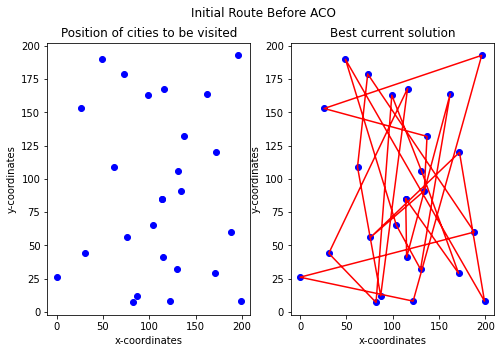

0  Best distance:  1071.995059085015
1  Best distance:  1071.995059085015
2  Best distance:  1071.995059085015
3  Best distance:  1071.995059085015
4  Best distance:  1071.995059085015
5  Best distance:  1071.995059085015
6  Best distance:  1071.995059085015
7  Best distance:  1071.995059085015
8  Best distance:  1056.5060835720672
9  Best distance:  1006.6464232007725
10  Best distance:  1006.6464232007725
11  Best distance:  1006.6464232007725
12  Best distance:  1006.6464232007725
13  Best distance:  1006.6464232007725
14  Best distance:  1006.6464232007725
15  Best distance:  1006.6464232007725
16  Best distance:  1006.6464232007725
17  Best distance:  1006.6464232007725
18  Best distance:  1006.6464232007725
19  Best distance:  1006.6464232007725
20  Best distance:  1006.6464232007725
21  Best distance:  1006.6464232007725
22  Best distance:  1006.6464232007725
23  Best distance:  1006.6464232007725
24  Best distance:  1006.6464232007725
25  Best distance:  1006.6464232007725
26  

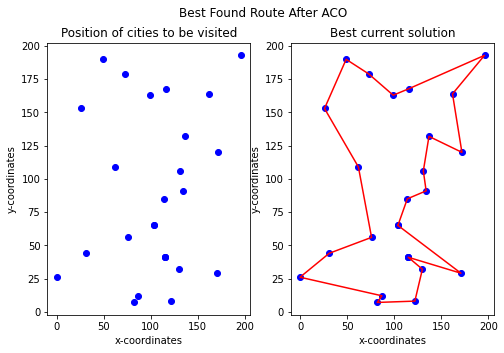

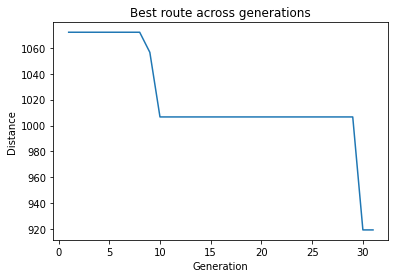

In [ ]:
# Set the percentage of ants based on the total number of cities
NUMBER_OF_ANTS_FACTOR = 0.5
# Set the number of tours ants must complete
TOTAL_ITERATIONS = 100
# Set the rate of pheromone evaporation (0.0 - 1.0)
EVAPORATION_RATE = 0.4
# Set the probability of ants choosing a random city to visit (0.0 - 1.0)
RANDOM_CITY_FACTOR = 0.15
# Set the weight for pheromones on path for selection
ALPHA = 4
# Set the weight for heuristic of path for selection
BETA = 7

get_user_selection()
initial_route = city_list + [city_list[0]]
plot_route(initial_route,'Initial Route Before ACO')
aco = ACO(NUMBER_OF_ANTS_FACTOR)
aco.solve(TOTAL_ITERATIONS, EVAPORATION_RATE)
route = parse_visited_cities_indexes(aco.best_ant.get_visited_cities())
pretty_print_route(route)
plot_route(route, 'Best Found Route After ACO')
plot_progress(aco.progress)

---
### Dependencies:
---
If you are running this program on a different IDE:
- Install latest version of Numpy
- Install latest version of Matplotlib


---
### Limitations:
---

The most noticeable limitation of this solution, is that it depends on two globally defined graphs that contain the distances and the pheromone trails between each city.

---
### Future Improvements:
---

Future improvements to this solution would include making some class that stores the distances and pheromones so that these graphs are not defined globally.

Another improvement would be to make this solution work with real life maps

---
###Conclusion
---
Implementing ACO is usefull for optimization problems like optimal task schedules or, in this case, finding shortest path. In addition, is very efficient because it doesn't require as much of computational resources as other traditional solutions like brute force. With the ants having a concept of memory and performance, plus using the pheromones, the program can efficiently search for the shortest path to the destination

---

### References
---
*   Course's textbook - "Grokking Artificial Intelligence Algorithms" by Rishal Hurbans

*   Code used as a reference and starting point: Code from the Grokking Artificial Intelligence Algorithms by Rishal Hurbans (chapter 6 ) URL: https://github.com/rishal-hurbans/Grokking-Artificial-Intelligence-Algorithms  

*   Reference explanation for Ranking Selection from StackOverflow - https://stackoverflow.com/questions/20290831/how-to-perform-rank-based-selection-in-a-genetic-algorithm

*  Initialization of distances graph by Rochakgupta - https://github.com/rochakgupta/aco-tsp